In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf
import json

In [206]:
import FIRE as fire
import imp
imp.reload(fire)

<module 'FIRE' from '/media/erik/Samsung_SSD/1_Data/11_Finances/1192_Planning/230806_FIRE/fire-calculator/FIRE.py'>

# Notes

All values are expressed in todays (nominal) €'s. This makes estimation of prices easier as they can be judged from today.
Thus, also things like the earings/monthly investment growth shall not consider the effects of inflation.

# Setup

In [207]:
# Boundary conditions / external effects
conditions = fire.FIREExternalConditionsArray('../External.json').select("SCENARIO_AVERAGE_INFLATION_AND_CAPITAL_TAX")

# Income/assets + Investments
investments = fire.FIREInvestmentArray('../Investments.json').select("SCENARIO_1")

# Target
target = fire.FIRETargetArray('../Targets.json').select("SCENARIO_INCOME_AGGRESSIVE")

# Simulation
simulation = fire.FIRESimulation(investments=investments, target=target, conditions=conditions)

# Investment analysis

/home/erik/Software/miniconda3/envs/dev/lib/python3.11/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: divide by zero encountered in divide
  (1 + rate*when)*(temp - 1)/rate)
/home/erik/Software/miniconda3/envs/dev/lib/python3.11/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in divide
  (1 + rate*when)*(temp - 1)/rate)


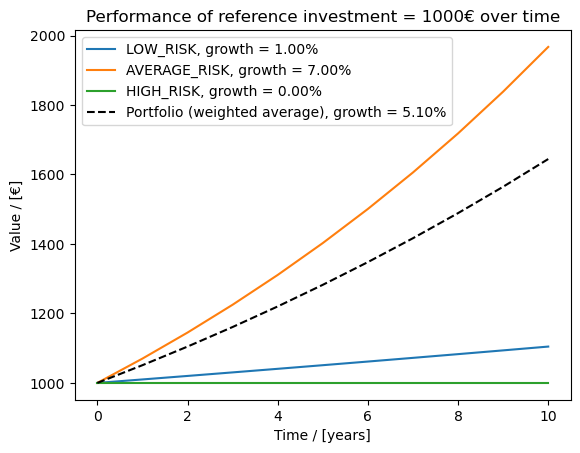

In [208]:
investments.plot_portfolio_performance("FIX")

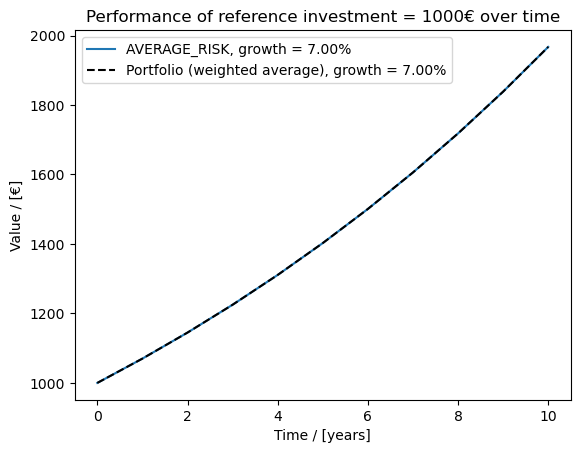

In [209]:
investments.plot_portfolio_performance("VAR")

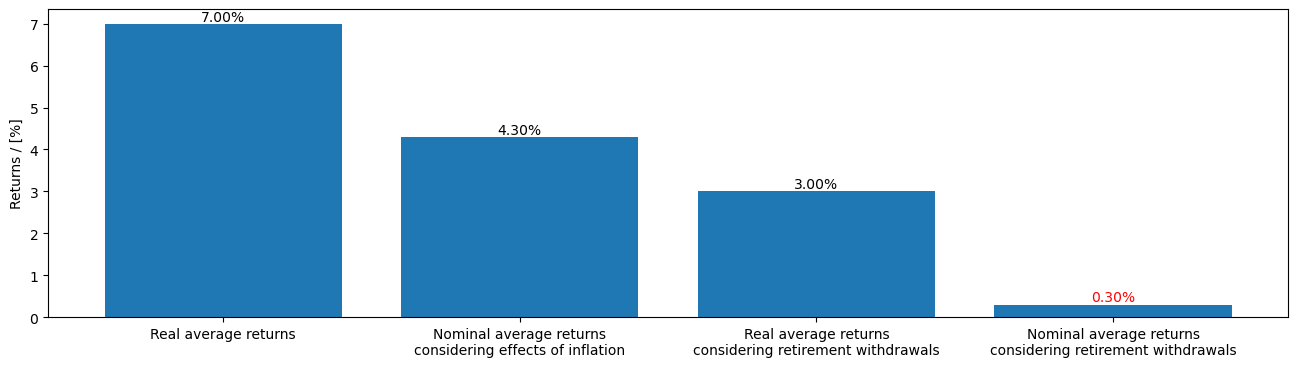

In [210]:
plt.figure(figsize=(16,4))
simulation.plot_growth_rates()

# Target analysis

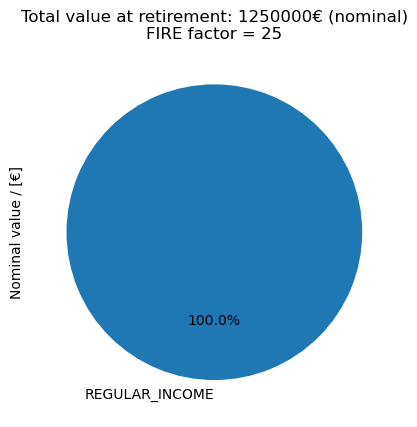

In [211]:
target.plot_pie_value()

# FIRE analysis

In [213]:
sim_res = simulation.perform()

sim_res = {"valuation" : [initial_assets],
           "investment": [investments_monthly],
           "time" : [0],
           "is_ret": [False],
           "ret_time":None,
          "taxes_cum" : [0]}

value_onetime_invest = target_df[target_df.frequency == "ONE_TIME"].value.sum()
value_yearly_invest = target_df[target_df.frequency == "YEARLY"].value.sum()

for p in range(1,71):
    was_ret = sim_res["is_ret"][-1]
    
    v_im1, i_im1 = sim_res["valuation"][-1], sim_res["investment"][-1]
    
    if was_ret:
        i_i = 0.0
        exp_i = value_yearly_invest
    else:
        i_i = investment_growth_perc/100.*i_im1+i_im1
        exp_i = 0
    
    v_i_yrly_n = i_i*12
    v_i_mty = npf.fv(avg_yield/100./12., 12, -i_i, -0, when="begin") ## annualize monthly returns: https://financetrain.com/how-to-annualize-monthly-returns-example
    v_i = npf.fv(avg_yield/100., 1, -v_i_mty+exp_i, -v_im1, when="end")
        
    # taxes
    v_tax = capital_tax_rate_perc/100*(v_i-v_im1-v_i_yrly_n)
    v_i -= v_tax
    
    is_ret = (v_i>=target_value_total_ret_nom)
    
    if is_ret and not was_ret:
        sim_res["ret_time"] = p
        v_i -= value_onetime_invest
    
    sim_res["valuation"].append(v_i)
    sim_res["investment"].append(i_i)
    sim_res["time"].append(p)
    sim_res["is_ret"].append(is_ret or was_ret)
    sim_res["taxes_cum"].append(sim_res["taxes_cum"][-1]+v_tax)
    

Text(0, 0.5, 'Age / [years]')

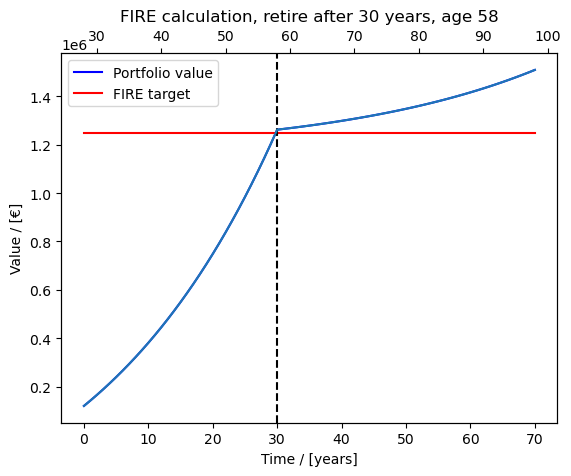

In [155]:
plt.figure()
if sim_res['ret_time'] is None:
    plt.title(f"FIRE calculation, no retirement in selected time span")    
else:
    plt.title(f"FIRE calculation, retire after {sim_res['ret_time']} years, age {sim_res['ret_time']+age}")
plt.plot(sim_res["time"], sim_res["valuation"], label = "Portfolio value", c="blue")
plt.plot(sim_res["time"], [target_value_total_ret_nom for i in sim_res["time"]],label = "FIRE target",c="red")
if sim_res['ret_time'] is not None:
    plt.axvline(sim_res["ret_time"], c="black",ls="--")
plt.legend()
plt.xlabel("Time / [years]")
plt.ylabel("Value / [€]")

ax2=plt.twiny()
ax2.plot(np.array(sim_res["time"])+age,sim_res["valuation"],alpha=1)
ax2.set_ylabel("Age / [years]")

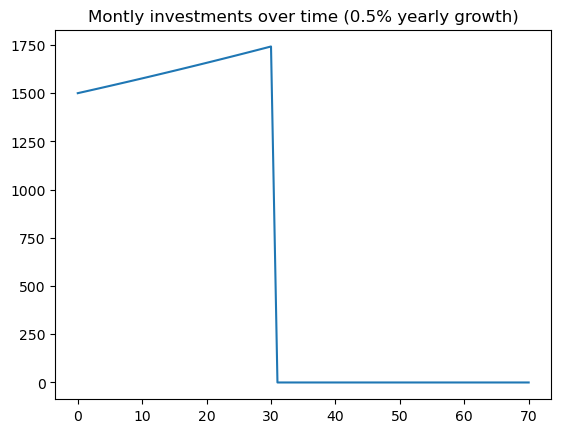

In [141]:
plt.title(f"Montly investments over time ({investment_growth_perc}% yearly growth)")
plt.plot(sim_res['time'], sim_res['investment'])